In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random


In [37]:
def pdf(x, a, b, x_max, x_min):
    numerator = 1 + a * x + b * x**2
    normalization = (x_max-x_min) + (a/2)*(x_max**2-x_min**2) + (b/3)*(x_max**3-x_min**3)
    return numerator / normalization

# Log-likelihood function
def log_likelihood(data, x_max, x_min):
    def log_likelihood_lambda(params):
        a, b = params
        likelihoods = [np.log(pdf(x, a, b, x_max, x_min)) for x in data]
        return -np.sum(likelihoods) 
    return lambda params: log_likelihood_lambda(params)

def estimate_a_b(data):
    x_min = np.min(data)
    x_max = np.max(data)

    # Parameter estimation with initial values
    initial_guess = [0.5, 0.5]
    result = minimize(log_likelihood(data, x_max, x_min), initial_guess, method="L-BFGS-B", bounds=[(-2, 2), (-2, 2)])

    # Results
    a, b = result.x

    # Errors estimated from the covariance matrix
    cov_matrix = result.hess_inv.todense()
    errors = np.sqrt(np.diag(cov_matrix))

    resulting_pdf = lambda x : pdf(x, a, b, x_max, x_min) 

    return a, b, errors, resulting_pdf


Stima di a: 0.298 +/- 0.276
Stima di b: 0.929 +/- 0.535


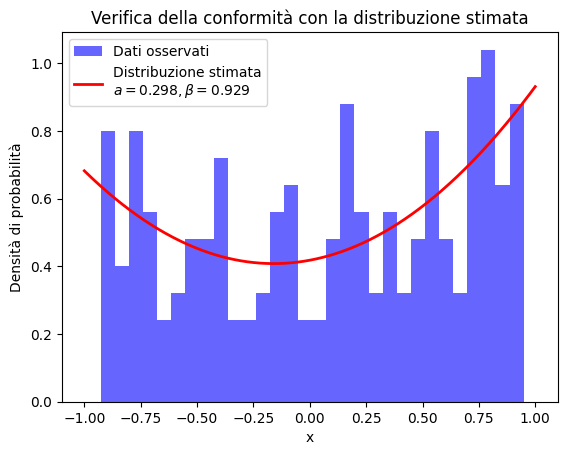

In [38]:
data = np.loadtxt("data_proj_one.dat")

a, b, errors, estimated_pdf = estimate_a_b(data)

print(f"Stima di a: {a:.3f} +/- {errors[0]:.3f}")
print(f"Stima di b: {b:.3f} +/- {errors[1]:.3f}")

# Generation of points for the estimated distribution
x_values = np.linspace(-1, 1, 500)
pdf_values = [estimated_pdf(x) for x in x_values]


# Plot comparison between histogram of data and the estimated curve
plt.hist(data, bins=30, density=True, alpha=0.6, color='blue', label='Dati osservati')
plt.plot(x_values, pdf_values, color='red', linewidth=2, label=f'Distribuzione stimata\n$a={a:.3f}, \\beta={b:.3f}$')
plt.title('Verifica della conformità con la distribuzione stimata')
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()

In [ ]:
# Function for random generation
# using the Monte Carlo method
def generate_random_monte_carlo(pdf, n_samples, samples_range):
    x_min, x_max = samples_range
    samples = []
    while len(samples) < n_samples:
        sample = random.uniform(x_min,x_max)
        random_picker = random.random()
        if(pdf(sample) > random_picker):
            samples.append(sample)
    return samples

estimated_a = []
estimated_a_error = []
estimated_b = []
estimated_b_error = []

# Generating 500 elements
for _ in range(500):
    new_x = generate_random_monte_carlo(estimated_pdf, 2000, (-0.95,0.95))
    a,b,errors,_ = estimate_a_b(new_x)
    estimated_a.append(a)
    estimated_b.append(b)
    estimated_a_error.append(errors[0])
    estimated_b_error.append(errors[1])

Text(0, 0.5, 'b')

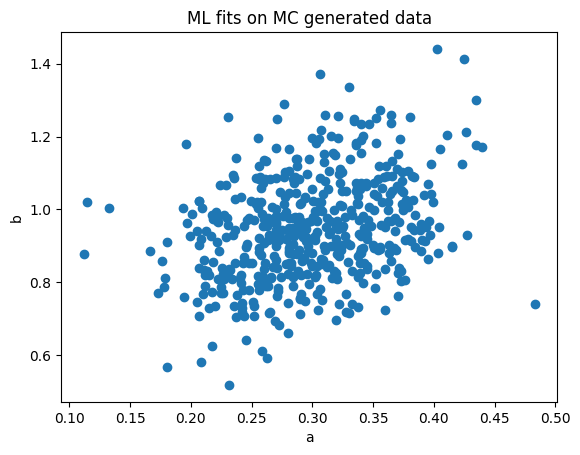

In [54]:
# Visualizations of data generated via Monte Carlo
plt.title('ML fits on MC generated data')    
plt.scatter(estimated_a,estimated_b,)
plt.xlabel('a')
plt.ylabel('b')

Estimated a: 0.299 +/- 0.239 +/- 0.219


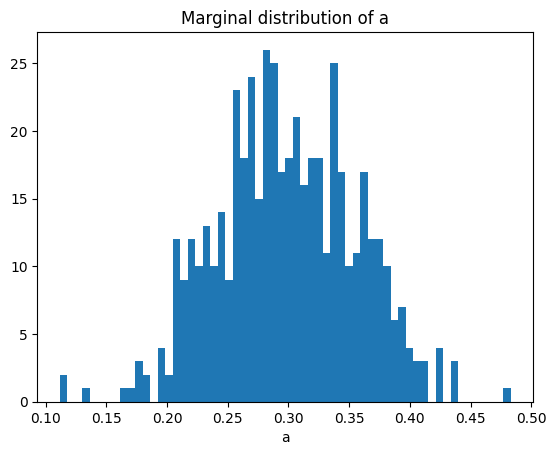

In [55]:
plt.hist(estimated_a,60)
plt.title('Marginal distribution of a') 
plt.xlabel('a')
mean_a = np.mean(estimated_a)
error_a = np.std(estimated_a)**(1/2)
estimated_a_error_mean = np.mean(estimated_a_error)
print(f"Estimated a: {mean_a:.3f} +/- {error_a:.3f} +/- {estimated_a_error_mean:.3f}")

Estimated b: 0.947 +/- 0.377 +/- 0.265


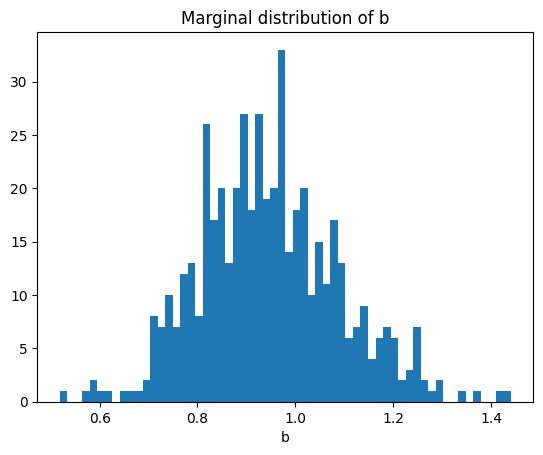

In [58]:
plt.hist(estimated_b,60)
plt.title('Marginal distribution of b') 
plt.xlabel('b')

mean_b = np.mean(estimated_b)
error_b = np.std(estimated_b)**(1/2)
estimated_b_error_mean = np.mean(estimated_b_error)
print(f"Estimated b: {mean_b:.3f} +/- {error_b:.3f} +/- {estimated_b_error_mean:.3f}")